## TensorFlow DataSet 만들기
- 기존에 생성한 학습 데이터 폴더를 활용하여 TensorFlow DataSet을 생성한다.

In [ ]:
# 데이터 정보
cfg = {
    'train_size': (512, 512),  # 인풋 이미지 크기
    'dict_label': {
        '02': {'00': 0, '03': 1, '04': 2},  # 고추마일드, 고추점무늬
        '05': {'00': 3, '09': 4, '10': 5},  # 상추균핵병, 상추노균병
        '11': {'00': 6, '18': 7, '19': 8},  # 토마토황화잎, 토마토잎곰팡이
    }
}
num_classes = 3 + 3 + 3

### 데이터 정제 (Data Cleaning)
- 라벨링이 잘못된 데이터를 삭제
  - conf['dict_label']에 없는 라벨을 가진 데이터는 삭제한다.

In [ ]:
# 데이터 로드

all_data = []
root_path = f"/content/{Dataset_name}/"

for root, dirs, files in os.walk(root_path+"train"):
        for file in files:
            all_data.append(os.path.join(root, file))

for root, dirs, files in os.walk(root_path+"valid"):
        for file in files:
            all_data.append(os.path.join(root, file))


print(len(all_data))

In [ ]:
import os

def delete_file(file_path):
    try:
        # 파일이 존재하는지 확인
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"{file_path} 파일이 성공적으로 삭제되었습니다.")
        else:
            print(f"{file_path} 파일을 찾을 수 없습니다.")
    except Exception as e:
        print(f"{file_path} 파일을 삭제하는 중 오류가 발생했습니다: {e}")

In [ ]:
# 유효한 질병 코드 리스트
valid_disease_codes = ['00', '03', '04', '09', '10', '18', '19']
valid_area_codes = ['00', '01', '02', '03', '04', '05', '06', '07']
valid_type_codes = ['02', '05', '11']

error_data_num = 0
error_data_paths = []

for path in all_data:
    basename = os.path.basename(path)
    disease = get_plant_disease_code(basename)
    type_ = get_plant_type_code(basename)
    area = get_plant_area_code(basename)
    if not (disease in valid_disease_codes and \
            type_ in valid_type_codes and area in valid_area_codes):
        error_data_num += 1
        error_data_paths.append(path)

# 데이터 삭제
for path in error_data_paths:
    delete_file(path)
    all_data.remove(path)

# 삭제된 파일 수 출력
print("삭제된 데이터 수:", error_data_num)

In [ ]:
# 현재 데이터 요약
import os

# 중복 없이 각 코드들을 저장할 집합
area_code = set()
type_code = set()

# 질병 코드 빈도를 저장할 딕셔너리 초기화
disease_code = {}

# 학습 데이터에서 질병 코드 빈도 계산
for path in all_data:
    basename = os.path.basename(path)

    # 지역 코드와 타입 코드는 집합에 추가
    area_code.add(get_plant_area_code(basename))
    type_code.add(get_plant_type_code(basename))

    # 질병 코드는 딕셔너리로 빈도 계산
    disease = get_plant_disease_code(basename)
    if disease not in disease_code:
        disease_code[disease] = 0
    disease_code[disease] += 0.5

# 코드 출력
print("Type Code:", type_code)
print("Area Code:", area_code)
print("Disease Code Frequency:", disease_code)


### 데이터셋 구축 (Building Dataset)
- TensorFlow에서 제공하는 tf.data.Dataset API를 사용하여 데이터셋을 구축하고 관리

#### util 함수
- 특정 폴더안의 해당 확장자를 가진 파일들을 읽어오기
- 이미지와 라벨이 서로 대응되는지 검수
- 파일 이름에서 식물의 특정 코드를(부위, 종류,질병) 추출하는 함수

In [ ]:
def list_files_in_folder(folder_path, extensions=None):
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if extensions:
                if any(file.lower().endswith(ext) for ext in extensions):
                    file_paths.append(os.path.join(root, file))
            else:
                file_paths.append(os.path.join(root, file))
    return sorted(file_paths)

def is_same_filename(file1, file2):
  # 파일 확장자를 제거한 파일 이름을 가져옴
    base1 = os.path.basename(file1).split('.')[0]
    base2 = os.path.basename(file2).split('.')[0]

    # 확장자를 제거한 파일 이름이 같은지 비교
    return base1 == base2

In [ ]:
import re

# 식물 종류 코드 반환 함수
def get_plant_type_code(filename):
    # '_'를 기준으로 분할하고 5번째 요소 식물 종류 코드 반환 -> Class name 설정을 위해
    token = filename.split('_')
    if len(token) >= 7:
        return token[4]
    else:
        return False


# 식물 부위 코드 반환 함수
def get_plant_area_code(filename):
    # '_'를 기준으로 분할하고 6번째 요소 식물 부위 코드 반환
    token = filename.split('_')
    if len(token) >= 7:
        return token[5]
    else:
        return False

# 식물 질병 코드 반환 함수
def get_plant_disease_code(filename):
    # '_'를 기준으로 분할하고 3번째 요소 식물 질병 코드 반환
    token = filename.split('_')
    if len(token) >= 7:
        return token[3]
    else:
        return False

#### dataset 관련 함수
- 이미지와 라벨을 로드 및 전처리하는 함수
- 주어진 이미지 파일 경로와 라벨 파일 경로를 사용하여 데이터셋을 생성하는 함수
- albumentations 객체
  - 데이터 증강 및 정규화 라이브러리

In [ ]:
import json
import tensorflow as tf

# 이미지와 라벨을 로드 및 전처리하는 함수
def load_image_and_label(image_path, label_path):

    # 이미지 로드 및 RGB 변환
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # 이미지를 원하는 크기로 조정
    image = tf.image.resize(image, cfg['train_size'])  # cfg['train_size'] = (512, 512)

    # 이미지 정규화
    augmented_image = test_aug(image=image.numpy())['image']

    ### 파일 이름으로 라벨링
    label_path_name = label_path.numpy().decode("utf-8")

    # 파일 이름에서 라벨 추출
    basename = os.path.basename(label_path_name)
    crop_code = get_plant_type_code(basename)
    disease_code = get_plant_disease_code(basename)

    label = cfg['dict_label'][crop_code][disease_code]

    """
    # JSON 어노테이션 로드
    with open(label_path.numpy().decode("utf-8"), 'r') as json_file:
        json_decoded = json.load(json_file)

    # 어노테이션에서 라벨 추출

    crop_code = f'{int(json_decoded["annotations"]["crop"]):02d}'
    disease_code = f'{int(json_decoded["annotations"]["disease"]):02d}'
    if crop_code == '01' or disease_code =='01':
      print(image_path)
      print(label_path)
      label = 0
    else:
      label = cfg['dict_label'][crop_code][disease_code]
    """

    return augmented_image, label

In [1]:
# 데이터셋 생성 함수
def create_dataset(image_paths, label_paths, batch_size):
    """
    주어진 이미지 파일 경로와 라벨 파일 경로를 사용하여 데이터셋을 생성합니다.

    Args:
        image_paths (list): 이미지 파일의 경로를 포함하는 리스트.
        label_paths (list): 라벨 파일의 경로를 포함하는 리스트.
        batch_size (int): 배치 크기.

    Returns:
        tf.data.Dataset: 이미지와 라벨에 대한 데이터셋.
    """

    # 이미지 파일 경로와 라벨 파일 경로를 텐서로부터 슬라이스하여 데이터셋 생성
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    # 각 이미지와 라벨에 대해 로드 및 전처리를 수행하는 함수를 적용
    # tf.py_function은 TensorFlow에서 python 함수를 텐서플로 그래프 안에서 실행할 수 있게 해주는 함수
    # func: Python 함수로 변환할 함수입니다. 이 함수는 텐서를 입력으로 받아들이고 텐서를 반환해야 합니다.
    # inp: Python 함수에 전달될 입력 텐서나 텐서의 목록입니다.
    # Tout: Python 함수의 반환값의 데이터 타입을 지정합니다. 이 값은 텐서 또는 텐서의 목록이 될 수 있습니다.
    # name: 연산의 이름을 지정합니다. 선택적 매개변수입니다.
    dataset = dataset.map(lambda x, y: tf.py_function(
        func=load_image_and_label,
        inp=[x, y],
        Tout=[tf.float32, tf.int64]
    ), num_parallel_calls=tf.data.experimental.AUTOTUNE)  # num_parallel_calls은 전처리할때 병렬처리 수 설정
    # tf.data.experimental.AUTOTUNE은 TensorFlow가 데이터를 효율적으로 처리하기 위해 필요한 병렬 처리 수를 자동으로 결정

    # 데이터셋 요소의 형태를 정의 (이미지의 크기를 다시한번 resize하는 이유는 보험으로 하는것이다)
    dataset = dataset.map(lambda x, y: (tf.ensure_shape(x, (512, 512, 3)), tf.ensure_shape(y, ())))

    # 데이터셋을 배치로 묶음
    dataset = dataset.batch(batch_size)

    # 데이터셋을 사용하기 전에 미리 준비하여 성능을 최적화
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

##### 데이터 정규화
- albumentations: 데이터 증강 및 정규화 라이브러리
  - Compose : 여러 변환을 하나로 붂는다
    - Normalize 변환 : 각 채널을 기준으로 이미지를 정규화 (3,512,512)
      - mean과 std 매개변수를 통해 각 채널의 평균과 표준 편차 지정하고 그에 맞춰 픽셀 값 변환
      - max_pixel_value는 기존의 픽셀이 가지고있는 최소, 최대 픽셀 값을 명시
      - p=1.0은 정규화는 반드시 적용함
    - Compose의 p=1.0은 가지고 있는 모든 변환을 적용한다
- 해당 정규화 값의 범위
  - R 채널: [-2.118, 2.251]
  - G 채널: [-2.036, 2.427]
  - B 채널: [-1.804, 2.640]

In [ ]:
# 이미지 데이터 증강 라이브러리
import albumentations
import numpy as np

test_aug = albumentations.Compose([albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225],
                                                             max_pixel_value=255.0,
                                                             p=1.0)
                                   ],
                                   p=1.0)

#### 실행

In [ ]:
# 확장자
image_extensions = ['.jpg', '.jpeg', '.png']
label_extensions = ['.json']

# 이미지 및 레이블 경로 리스트 생성
train_folder = '/content/CustomDataSet/train'
valid_folder = '/content/CustomDataSet/valid'

In [ ]:
image_files = list_files_in_folder(train_folder, image_extensions)
label_files = [f'{path}.json' for path in image_files]

valid_image_files = list_files_in_folder(valid_folder, image_extensions)
valid_label_files = [f'{path}.json' for path in valid_image_files]

print(valid_image_files[0])
print(valid_label_files[0])

In [ ]:
# 데이터셋 생성
batch_size = 1
train_dataset = create_dataset(image_files, label_files, batch_size)
valid_dataset = create_dataset(valid_image_files, valid_label_files, batch_size)

In [ ]:
len(train_dataset)

#### (번외) 데이터셋 순회 방법
- tensorflow
  - for 루프 사용
    - for data in dataset:
  - iter()와 next() 함수사용
    - iter()을 통해 순회하고 다음 배치를 탐색하기위해선 next()를 사용한다.
      - 장점: 한 번에 하나의 배치만 가져오기 때문에 메모리 사용자가 적다
  - take() 함수 사용
    - data = dataset.take(1)  # 첫 번째 데이터 가져오기
      - 일정 수의 요소를 쉽게 가져올 수 있다.
  - map()과 reduce() 함수등 함수형 프로그래밍 방식

* tf.data.experimental.cardinality(dataset_name) : 데이터 셋의 크기 확인
  - len()과 달리 크기가 동적으로 변하거나 무한할때도 사용가능

In [ ]:
tf.data.experimental.cardinality(train_dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=94>

In [ ]:
for image, label in train_dataset.take(1):
  print(image.numpy()[0][2].max())
  print(image.numpy()[0][0].min())
  print(image.numpy())

2.3676689
-1.6217272
[[[[ 0.3633959   1.2811276   1.0967845 ]
   [ 0.39115673  1.3051313   1.1206815 ]
   [ 0.38364795  1.3269979   1.0901634 ]
   ...
   [-1.3008492  -0.18501548 -1.3007509 ]
   [-1.2001075  -0.11156814 -1.2069328 ]
   [-1.13992    -0.10802912 -1.1402287 ]]

  [[ 0.47567677  1.401984    1.2143635 ]
   [ 0.32275808  1.323835    1.1098903 ]
   [ 0.38122305  1.359533    1.1392682 ]
   ...
   [-1.2425848  -0.21298565 -1.2447188 ]
   [-1.2207943  -0.16225979 -1.246506  ]
   [-1.1875482  -0.16084076 -1.218626  ]]

  [[ 0.43582493  1.4306722   1.22061   ]
   [ 0.43182802  1.3572932   1.1726116 ]
   [ 0.47246587  1.3700987   1.2352479 ]
   ...
   [-1.2044221  -0.17397103 -1.2058775 ]
   [-1.2479364  -0.15827627 -1.2033244 ]
   [-1.0731435  -0.03210276 -1.1539644 ]]

  ...

  [[ 1.6495419   2.4285712   2.4831371 ]
   [ 1.5810428   2.4110644   2.4308496 ]
   [ 1.5973147   2.4201427   2.4436493 ]
   ...
   [ 0.9455539   1.0851824   1.6163071 ]
   [ 0.7994584   0.8701746   1.17458

### 데이터 증강(Data Augmentation)

#### 관련 함수
  - 이미지에 데이터 증강을 적용하는 함수
  - 이미지의 픽셀 값을 [0, 255] 범위로 역정규화 함수(CV2)
  - 이미지의 픽셀 값을 [0, 1] 범위로 역정규화 함수(PLT)

In [ ]:
def apply_augmentation(image, label):
    image = tf.image.flip_left_right(image)
    image = tf.image.adjust_brightness(image, 0.8)
    return image, label

In [ ]:
# cv2 라이브러리[0~255]에서 사용할 역정규화 함수 정의
def cv2_reverse_normalize(image):
    temp = image.copy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    temp *= std
    temp += mean
    temp *= 255.0
    temp = np.clip(temp, 0, 255)
    return temp

In [ ]:
# plt 라이브러리[0~1]에서 사용할 역정규화 함수 정의
def plt_reverse_normalize(image):
    temp = image.copy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    temp *= std
    temp += mean
    temp = np.clip(temp, 0, 1)
    return temp

#### 이미지 데이터 변환 실습
- 시각화를 통하여 이미지 데이터 변환을 확인

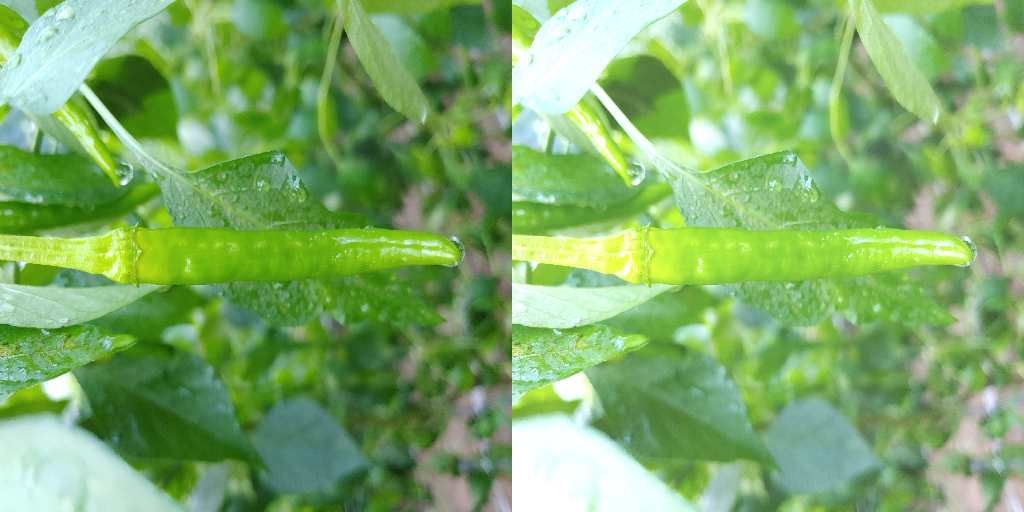

In [ ]:
# cv2로 시각화 및 밝기 조정 변환
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

image, label = next(iter(train_dataset))

# 반환되는 이미지는 (1,512,512,3) 형태이다. 변환이나 시각화를 하기위해선
# (512,512,3) 형태로 바꿔줘야한다
# squeeze() 길이가 1인 차원을 제거하여 배열의 의미 없는 차원을 없애준다.
image = image.numpy().squeeze() # === image.numpy()[0]

# 변환 (밝기 조정)
image2 = tf.image.adjust_brightness(image, 0.8)

# 첫 번째 이미지의 역정규화 및 시각화
image = cv2_reverse_normalize(image)
# OpenCV는 BGR 포맷을 사용하므로 RGB에서 BGR로 변환
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# 두 번째 이미지의 역정규화 및 시각화
# image2에서 .numpy()를 하는 이유는 변환을 거치면 tensorflow의 객체가 반환된다.
# 하지만 처리할 땐 numpy배열로 처리해야 되기 때문에 변환을 해준다.
image2 = cv2_reverse_normalize(image2.numpy())
# OpenCV는 BGR 포맷을 사용하므로 RGB에서 BGR로 변환
image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2BGR)

# 이미지를 가로로 나란히 시각화하기 위해 가로로 이어붙이기
concatenated_image = np.concatenate((image, image2), axis=1)

# 이미지를 cv2_imshow() 함수를 사용하여 표시
cv2_imshow(concatenated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


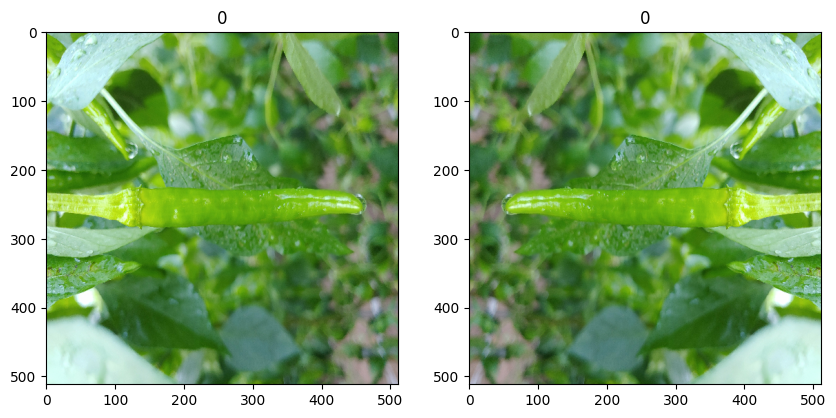

In [ ]:
# plt로 시각화 및 y축 대칭 변환
import numpy as np
import matplotlib.pyplot as plt

image, label = next(iter(train_dataset))
# 변환 (좌우 대칭)
# tf.image의 변환함수는 변환되는 이미지의 차원과 상관없이 변환해준다.
image2 = tf.image.flip_left_right(image)

# 이미지를 가로로 나란히 시각화하기
plt.figure(figsize=(10, 5))

# 첫 번째 이미지의 역정규화 및 시각화
image = plt_reverse_normalize(image.numpy()[0])
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(label.numpy()[0])

# 두 번째 이미지의 역정규화 및 시각화
image2 = plt_reverse_normalize(image2.numpy()[0])
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title(label.numpy()[0])

plt.show()

#### 실행

In [ ]:
# 기존 데이터셋에 데이터 증강 기법을 적용하여 새로운 데이터셋을 생성

# AUTOTUNE을 사용하여 데이터 전처리 작업을 병렬로 처리합니다.
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 증강된 aug_train_dataset을 생성합니다.
aug_train_dataset = train_dataset.map(apply_augmentation, num_parallel_calls=AUTOTUNE)

aug_train_dataset = aug_train_dataset.cache()  # 데이터셋을 캐시합니다.

# shuffle 함수를 사용하여 데이터셋을 섞을 수 있습니다. (선택 사항)
# aug_train_dataset = aug_train_dataset.shuffle(buffer_size=1000)

# prefetch 함수를 사용하여 데이터를 미리 로드하여 학습 시간을 최적화합니다.
aug_train_dataset = aug_train_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
print(type(aug_train_dataset))
print(type(train_dataset))
print(len(aug_train_dataset))
print(len(train_dataset))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
5998
5998


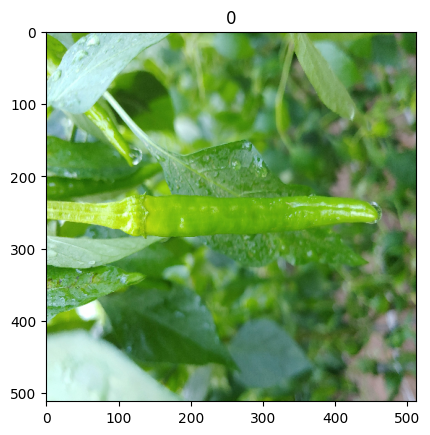

In [ ]:
# 원본 데이터셋의 이미지
dataset_iter = iter(train_dataset)
image, label = next(dataset_iter)
image = plt_reverse_normalize(image.numpy()[0])
plt.imshow(image)
plt.title(label.numpy()[0])
plt.show()

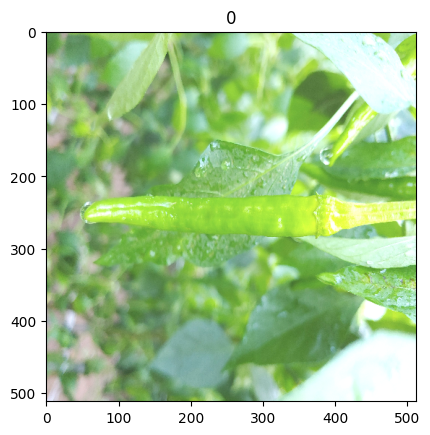

In [ ]:
# 증강기법이 적용된 데이터셋의 이미지
# y축 대칭 및 밝기 조절
aug_dataset_iter = iter(aug_train_dataset)
image, label = next(aug_dataset_iter)
image = plt_reverse_normalize(image.numpy()[0])
plt.imshow(image)
plt.title(label.numpy()[0])
plt.show()

In [ ]:
# 원본 데이터셋과 증강된 데이터셋 병합
combined_dataset = train_dataset.concatenate(aug_train_dataset)
len(combined_dataset) # 5998*2 =11996

11996